### Data Augmentation Techniques
* Scaling
* Translation
* Rotation (at 90 degrees)
* Rotation (at finer angles)
* Flipping
* Adding Salt and Pepper noise
* Lighting condition
* Perspective transform

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import os
import cv2
from math import floor, ceil, pi

%matplotlib inline

In [2]:
# Collect image file paths
def get_image_paths ():
    folder = './images/gauges'
    files = os.listdir(folder)
    files.sort()
    files = ['{}/{}'.format(folder, file) for file in files]
    return files

In [3]:
X_img_paths = get_image_paths()
print(X_img_paths[1:])

['./images/gauges/gauge_0-5.png', './images/gauges/gauge_0-6.png', './images/gauges/gauge_0-7.png', './images/gauges/gauge_0-8.png', './images/gauges/gauge_0-9.png', './images/gauges/gauge_0.png', './images/gauges/gauge_1-1.png', './images/gauges/gauge_1-2.png', './images/gauges/gauge_1-3.png', './images/gauges/gauge_1-4.png', './images/gauges/gauge_1-5.png', './images/gauges/gauge_1-6.png', './images/gauges/gauge_1-7.png', './images/gauges/gauge_1-8.png', './images/gauges/gauge_1-9.png', './images/gauges/gauge_1.png', './images/gauges/gauge_10-1.png', './images/gauges/gauge_10-2.png', './images/gauges/gauge_10-3.png', './images/gauges/gauge_10-4.png', './images/gauges/gauge_10-5.png', './images/gauges/gauge_10-6.png', './images/gauges/gauge_10-7.png', './images/gauges/gauge_10-8.png', './images/gauges/gauge_10-9.png', './images/gauges/gauge_10.png', './images/gauges/gauge_11-1.png', './images/gauges/gauge_11-2.png', './images/gauges/gauge_11-3.png', './images/gauges/gauge_11-4.png', '

In [4]:
IMAGE_SIZE = 224

# Image Resizing
def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (IMAGE_SIZE, IMAGE_SIZE), 
                                    tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

In [5]:
X_imgs = tf_resize_images(X_img_paths[1:])
print(X_imgs.shape)

(147, 224, 224, 3)


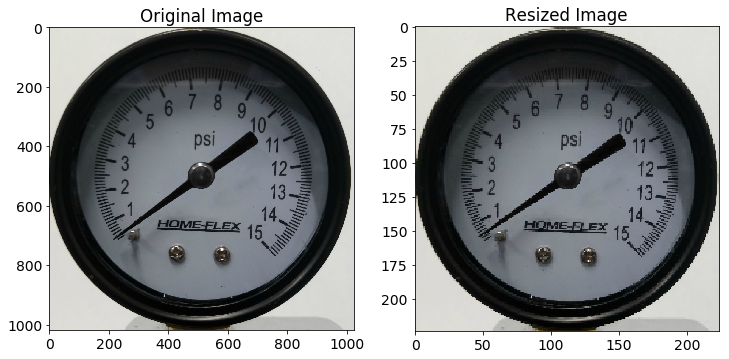

In [6]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(X_img_paths[1])[:,:,:3])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_imgs[1])
plt.title('Resized Image')
plt.show()

#### Scaling:
Having differently scaled object of interest in the images is the most important aspect of image diversity. When your network is in hands of real users, the object in the image can be tiny or large. Also, sometimes, object can cover the entire image and yet will not be present totally in image (i.e cropped at edges of object). The code shows scaling of image centrally.

In [7]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data

In [8]:
# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(X_imgs[1:], [0.90, 0.75, 0.60])
print(scaled_imgs.shape)

(438, 224, 224, 3)


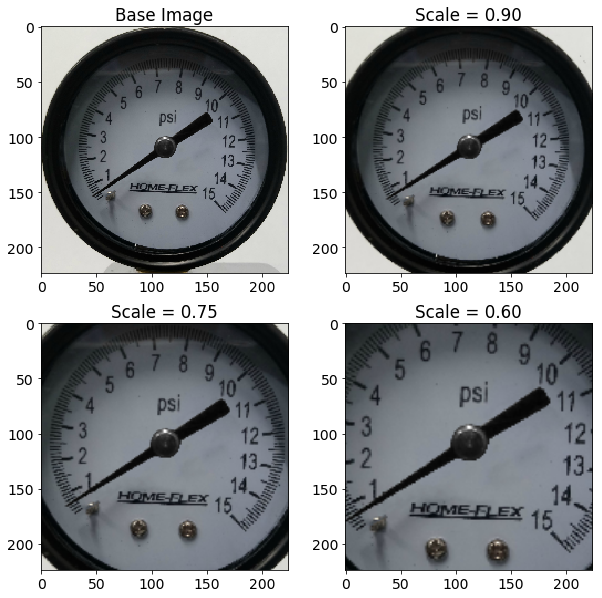

In [9]:
fig, ax  ==  plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[1])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(scaled_imgs[3])
plt.title('Scale = 0.90')
plt.subplot(2, 2, 3)
plt.imshow(scaled_imgs[4])
plt.title('Scale = 0.75')
plt.subplot(2, 2, 4)
plt.imshow(scaled_imgs[5])
plt.title('Scale = 0.60')
plt.show()

#### Translation:
We would like our network to recognize the object present in any part of the image. Also, the object can be present partially in the corner or edges of the image. For this reason, we shift the object to various parts of the image. This may also result in addition of a background noise. The code snippet shows translating the image at four sides retaining 80 percent of the base image.

In [10]:
def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    elif index == 3: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE
    elif index == 4: # Translate left 10 percent
        offset = np.array([0.0, 0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.9 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 5: # Translate right 10 percent
        offset = np.array([0.0, -0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE 
    elif index == 6: # Translate top 10 percent
        offset = np.array([0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.9 * IMAGE_SIZE))  
    elif index == 7: # Translate bottom 10 percent
        offset = np.array([-0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        h_end = IMAGE_SIZE      
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 8
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
			 w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

In [11]:
translated_imgs = translate_images(X_imgs[1:])
print(translated_imgs.shape)

(1168, 224, 224, 3)


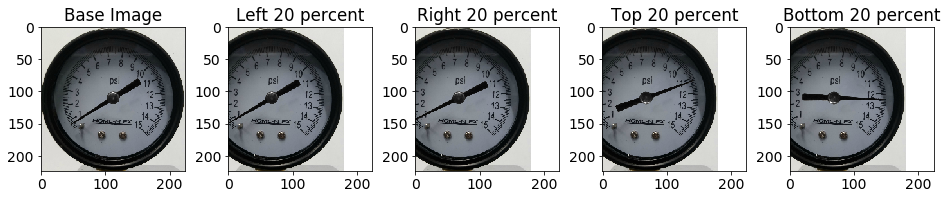

In [12]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[14])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[26])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[38])
plt.title('Bottom 20 percent')
plt.show()

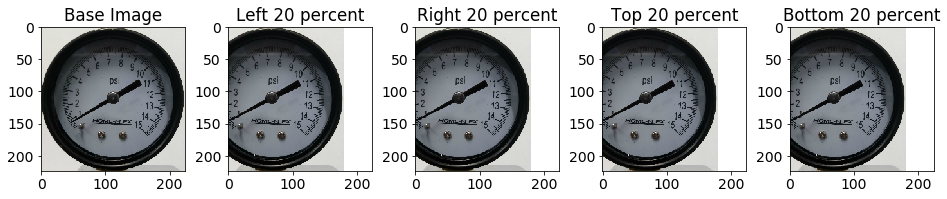

In [13]:
gs  ==  gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[3])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[3])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[3])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[3])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[3])
plt.title('Bottom 20 percent')
plt.show()

#### Rotation (at 90 degrees):
The network has to recognize the object present in any orientation. Assuming the image is square, rotating the image at 90 degrees will not add any background noise in the image.

In [14]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

In [15]:
rotated_imgs = rotate_images(X_imgs[1:])
print(rotated_imgs.shape)

(438, 224, 224, 3)


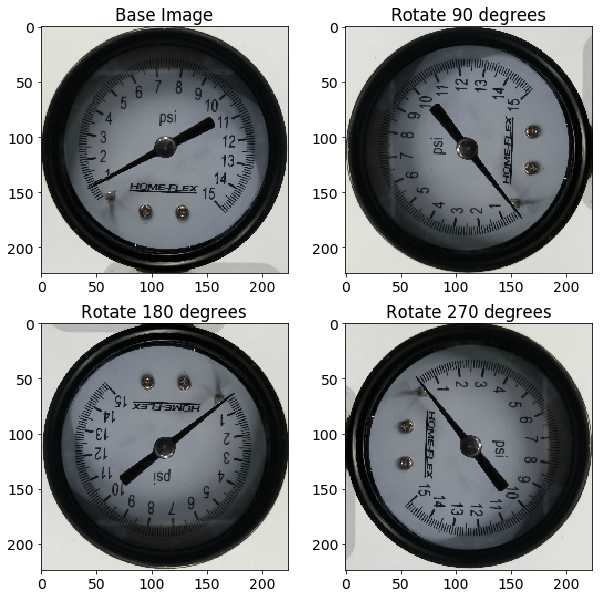

In [16]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[4])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[12])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[13])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[14])
plt.title('Rotate 270 degrees')
plt.show()

#### Rotation (at finer angles):
Depending upon the requirement, there maybe a necessity to orient the object at minute angles. However problem with this approach is, it will add background noise. If the background in image is of a fixed color (say white or black), the newly added background can blend with the image. However, if the newly added background color doesn’t blend, the network may consider it as to be a feature and learn unnecessary features.

In [17]:
def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * pi / 180  # Convert to radian
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

In [18]:
# Start rotation at -90 degrees, end at 90 degrees and produce totally 14 images# Start  
rotated_imgs = rotate_images(X_imgs[:1], -90, 90, 14)
print(rotated_imgs.shape)

(14, 224, 224, 3)


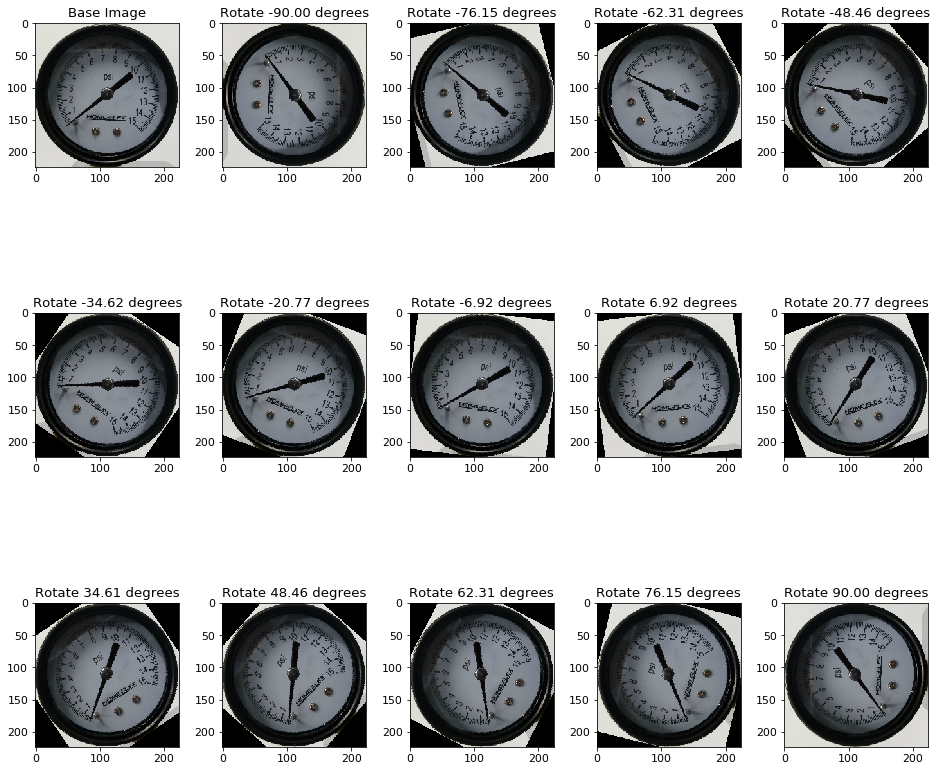

In [19]:
matplotlib.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize = (16, 16))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace = 0.30, hspace = 0.0002)

plt.subplot(gs[0])
plt.imshow(X_imgs[5])
plt.title('Base Image')

for i in range(14):
    plt.subplot(gs[i + 1])
    plt.imshow(rotated_imgs[i])
    plt.title('Rotate {:.2f} degrees'.format(-90 + 13.846 * i))
plt.show()

#### Flipping:
This scenario is more important for network to remove biasness of assuming certain features of the object is available in only a particular side. Consider the case shown in image example. You don’t want network to learn that tilt of banana happens only in right side as observed in the base image. Also notice that flipping produces different set of images from rotation at multiple of 90 degrees.My additional question is has anyone done some study on what is the maximum number of classes it gives good performance. Consider, data can be generated with good amount of diversity for each class and time of training is not a factor.

In [20]:
def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

In [21]:
flipped_images = flip_images(X_imgs[1:])
print(flipped_images.shape)

(438, 224, 224, 3)


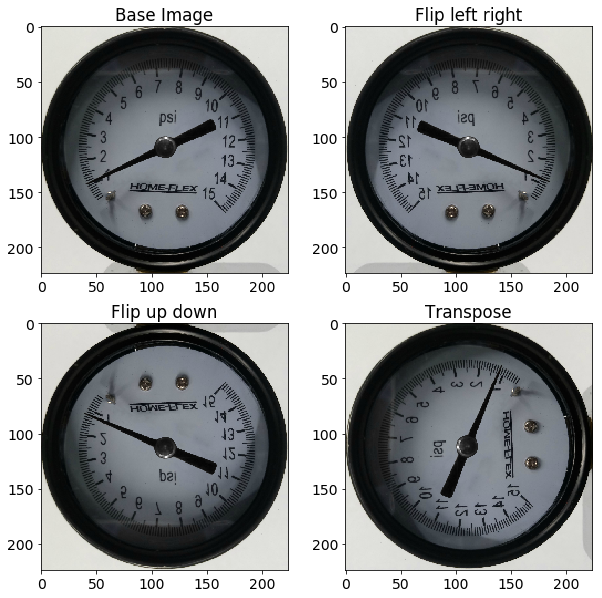

In [22]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[6])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(flipped_images[18])
plt.title('Flip left right')
plt.subplot(2, 2, 3)
plt.imshow(flipped_images[19])
plt.title('Flip up down')
plt.subplot(2, 2, 4)
plt.imshow(flipped_images[20])
plt.title('Transpose')
plt.show()

#### Adding Salt and Pepper noise:
Salt and Pepper noise refers to addition of white and black dots in the image. Though this may seem unnecessary, it is important to remember that a general user who is taking image to feed into your network may not be a professional photographer. His camera can produce blurry images with lots of white and black dots. This augmentation aides the above mentioned users.


In [23]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy

In [24]:
salt_pepper_noise_imgs = add_salt_pepper_noise(X_imgs[1:])
print(salt_pepper_noise_imgs.shape)

(146, 224, 224, 3)


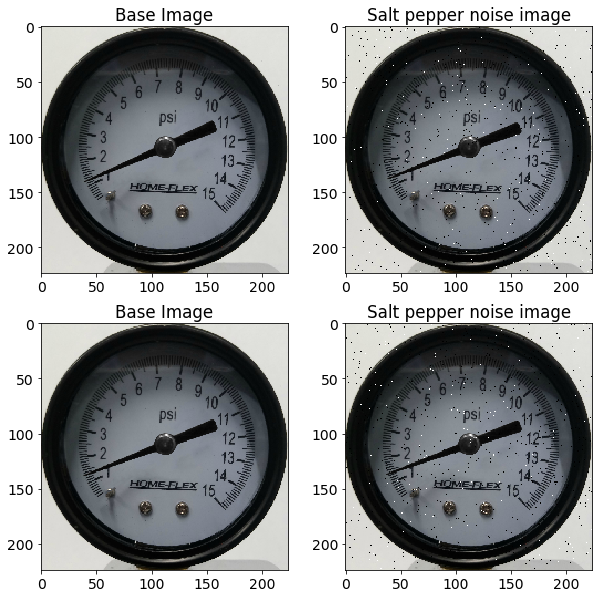

In [25]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[7])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_noise_imgs[7])
plt.title('Salt pepper noise image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[8])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(salt_pepper_noise_imgs[8])
plt.title('Salt pepper noise image')
plt.show()

#### Lighting condition:
This is a very important type of diversity needed in the image dataset not only for the network to learn properly the object of interest but also to simulate the practical scenario of images being taken by the user. The lighting condition of the images are varied by adding Gaussian noise in the image.

In [26]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [27]:
gaussian_noise_imgs = add_gaussian_noise(X_imgs[1:])
print(gaussian_noise_imgs.shape)

(146, 224, 224, 3)


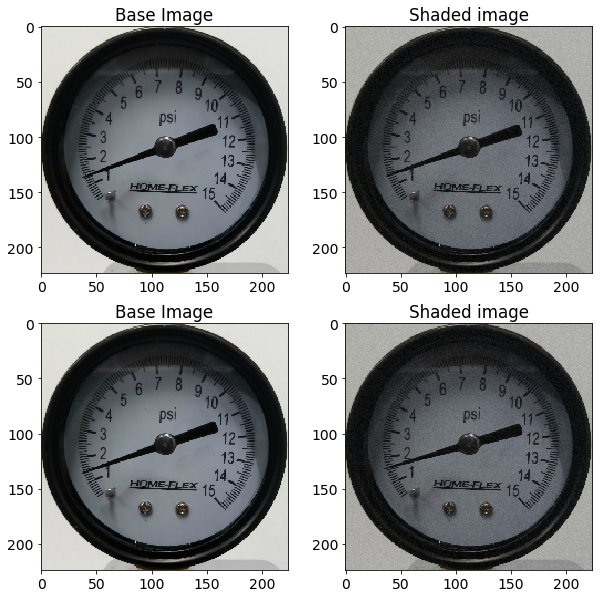

In [28]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[9])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(gaussian_noise_imgs[9])
plt.title('Shaded image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[10])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(gaussian_noise_imgs[10])
plt.title('Shaded image')
plt.show()

#### Perspective transform:
In perspective transform, we try to project image from a different point of view. For this, the position of object should be known in advance. Merely calculating perspective transform without knowing the position of the object can lead to degradation of the dataset. Hence, this type of augmentation has to be performed selectively. The greatest advantage with this augmentation is that it can emphasize on parts of object in image which the network needs to learn.

In [29]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix,
                                     (X_img.shape[1], X_img.shape[0]),
                                     flags = cv2.INTER_LINEAR)
    return warped_img

In [30]:
X_img = X_imgs[11]
perspective_img = perspective_transform(X_img[1:])
print(perspective_img.shape)

(223, 224, 3)


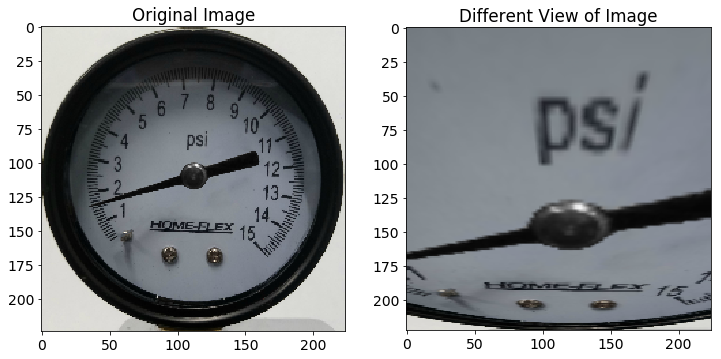

In [31]:
fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_imgs[11])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(perspective_img)
plt.title('Different View of Image')
plt.show()